# Cassandra driver.

Query Cassandra database to get activations for pages stored in JSON graph.

In [1]:
from cassandra.cluster import Cluster
from cassandra.cluster import ExecutionProfile
from cassandra import query
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import json

In [2]:
plt.style.use('seaborn-colorblind')
from pylab import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['xtick.labelsize'] = 25
rcParams['ytick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['legend.fontsize'] = 25

Read ids from JSON graph

In [3]:
with open('./data/graph.json') as json_file:  
    data = json.load(json_file)
pages = data['nodes']

In [4]:
page_id_title_dict = {}

for page in pages:
    page_id_title_dict[int(page['id'])] = page['label'].replace('_',' ')

In [5]:
print("Number of nodes: ", len(tuple(page_id_title_dict.keys())))

Number of nodes:  15038


Prepare Cassandra connection

In [6]:
cluster = Cluster()

In [7]:
session = cluster.connect()

In [8]:
session.set_keyspace("wikipedia")

In [9]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [10]:
session.row_factory = pandas_factory

In [11]:
session.default_fetch_size = 10000000 #needed for large queries, otherwise driver will do pagination. Default is 50000.

Query Cassandra

In [12]:
# page_id_title_dict = {20966: "Marvel Comics", 9105: "DC Comics"}

In [13]:
#NOTE: this query is time-consuming. Update cassandra.yaml `read_request_timeout_in_ms` to 50000 ms and `range_request_timeout_in_ms` to 10000
rows = session.execute("SELECT * FROM wikipedia.page_visits WHERE page_id IN " + str(tuple(page_id_title_dict.keys())))

In [14]:
rows_df = rows._current_rows

In [15]:
rows_df.shape

(2589123, 3)

Save the query result

In [16]:
rows_df.to_pickle('./data/activations_cassandra.pickle')

In [17]:
# rows_df.replace({'page_id': page_id_title_dict}, inplace=True)
rows_df.head()

,page_id,visit_time,count
0,734,2018-07-31 22:00:00,14
1,734,2018-07-31 23:00:00,8
2,734,2018-08-01 00:00:00,7
3,734,2018-08-01 01:00:00,11
4,734,2018-08-01 02:00:00,14


Groupby to plot

In [18]:
rows_df.set_index('visit_time', inplace=True)
# rows_df = rows_df.groupby('page_id')
rows_df = rows_df.loc[rows_df['page_id'] == 1394].groupby('page_id')

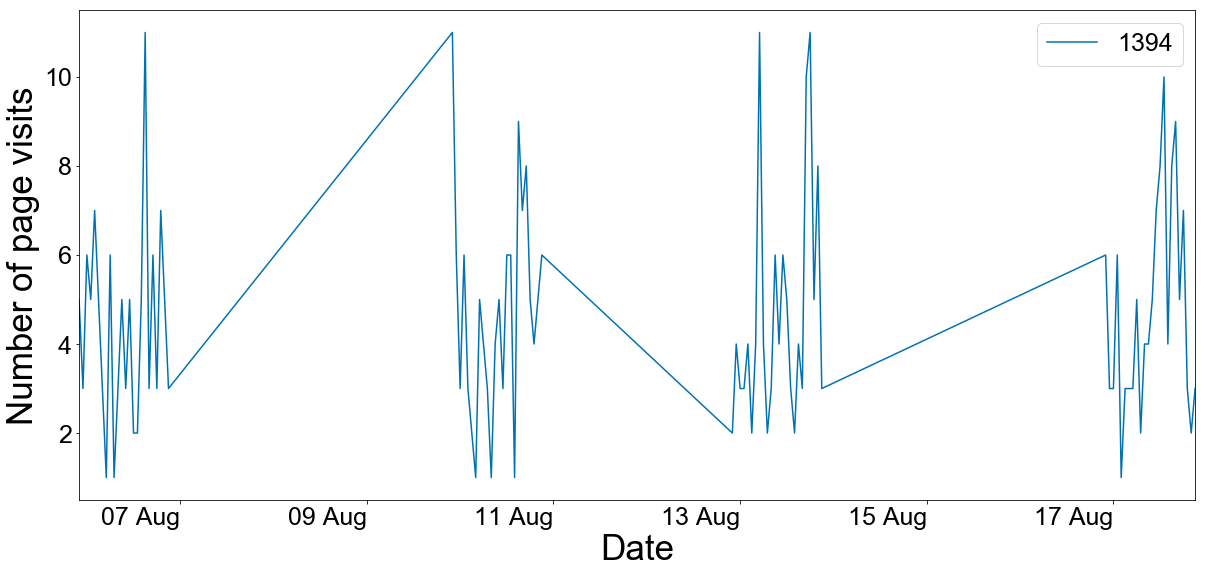

In [19]:
fig, ax = plt.subplots(figsize = (20,10))
rows_df['count'].plot(legend=True, x_compat=True)
plt.xlabel("Date")
plt.ylabel("Number of page visits")
plt.setp(ax.get_xticklabels(), rotation=0)
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d %b')
)
# plt.savefig("timeseries.pdf", format="PDF", bbox_inches='tight')